# Regression Practice

-- [SICSS Zürich 2021](https://github.com/computational-social-science-zurich/sicss-zurich) -- 

## Preambule

### <span style='color:green'> Questions to answer are in green</span>

## Objective of the Notebook
This notebook walks you through the estimation of the **gender pay gap** using a combination of linear regressions and regularization models. 

Policy makers have long been concerned with the gender earnings gap. We will examine the gender earnings gap using data from the 2018 Current Population Survey (CPS) in the US. In particular, we will use the version of the CPS provided by the NBER.

To be more concrete, consider the following regression model:
$$y=\theta d+f(x) +\epsilon,$$ 
Where
- $d$ is the regressor of interest: a `female` dummy
- $y_i$ is a the outcome of interest: labour earnings or wage
- $x_i$ is a set of controls

We are not interested in $x$ per se (but we need to include it to avoid omitted variable bias)- and $f(x)$ is some unknown function. Instead we are interested in the estimation of $\theta$. We will estimate how x affect both $y_i$ and $d_i$ using a regularized model before estimating the relating between $y_i$ and $d_i$ with a linear regression. In other words, we will use a machine learning model to estimate $f$ in an automated and data-driven way.  

This model is called a **partually linear model**: linear in $d$ but not in $x$. 


### Estimation procedure for $\theta$:
1. Predict $y$ and $d$ from $x$ using a machine learning method relying on cross-validation
2. Partial out $x$: let $\tilde y_i = y_i - \hat y_i$ and $\tilde d_i=d_i - \hat d_i$
3. Regress $\tilde y_i$ on $\tilde d_i$ to estimate $\hat \theta$

The notebook will walk you through the previous steps. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
#plt.style.use('tableau-colorblind10')
#plt.style.use('Solarize_Light2')
plt.style.use('bmh')
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

## 0. Download CPS data

In [2]:
cpsall = pd.read_stata("https://www.nber.org/morg/annual/morg18.dta")

In [3]:
# take subset of data just to reduce computation time
cps = cpsall.sample(30000, replace=False, random_state=0)
display(cps.head())
cps.describe()

,hhid,intmonth,hurespli,hrhtype,minsamp,hrlonglk,hrsample,hrhhid2,serial,hhnum,...,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc,docc00,dind02
103153,150909100105603,May,1.0,Civilian male primary individual,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0801,08011,1,1,...,700,697,0,0,0,0,0,NaN,Business and financial operations occupations,Professional and Technical services
76648,505760912076673,March,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0811,08111,1,1,...,698,695,0,0,0,0,0,12.0,NaN,NaN
51433,481462012350753,February,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0701,07011,1,1,...,697,694,0,0,0,0,0,NaN,Management occupations,Agriculture
75550,106518879410166,March,2.0,Husband/wife primary fam (neither in Armed For...,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0611,06111,1,1,...,698,683,0,0,0,0,0,11.0,NaN,NaN
284643,466023401171104,December,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0901,09011,1,1,...,707,704,0,1,1,0,1,13.0,Management occupations,Membership associations and organizations


,hurespli,hhnum,cbsafips,county,centcity,smsastat,icntcity,smsa04,relref95,age,...,recnum,year,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc
count,29997.000000,30000.000000,30000.000000,30000.000000,24701.000000,29689.000000,3845.000000,30000.000000,30000.000000,30000.000000,...,30000.00000,30000.0,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,21463.000000
mean,1.314898,1.052733,22812.328667,25.752033,1.926157,1.188150,1.377373,3.687667,3.200333,47.856967,...,217052.62500,2018.0,701.467433,692.357833,0.06040,0.065333,0.143033,0.086467,0.105033,12.355938
std,0.683163,0.245943,16494.302775,62.862911,0.721596,0.390839,0.946464,2.592477,3.291772,18.757968,...,125652.34375,0.0,3.467921,6.970577,0.23823,0.247117,0.350113,0.281057,0.306601,2.478719
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,16.000000,...,19.00000,2018.0,696.000000,681.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,...,108185.25000,2018.0,698.000000,686.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,1.000000,1.000000,25420.000000,0.000000,2.000000,1.000000,1.000000,4.000000,2.000000,48.000000,...,217388.50000,2018.0,701.000000,692.000000,0.00000,0.000000,0.000000,0.000000,0.000000,12.000000
75%,1.000000,1.000000,37900.000000,29.000000,2.000000,1.000000,1.000000,6.000000,3.000000,63.000000,...,325915.00000,2018.0,704.000000,698.000000,0.00000,0.000000,0.000000,0.000000,0.000000,14.000000
max,11.000000,8.000000,49740.000000,810.000000,3.000000,2.000000,7.000000,7.000000,18.000000,85.000000,...,434279.00000,2018.0,707.000000,704.000000,1.00000,1.000000,1.000000,1.000000,1.000000,18.000000


The variable `earnwke` records weekly earnings. Two variables detail the hours of work. `uhours` is usual hours worked per week, and `hourslw` is hours worked last week. We will try using each measure of hours to construct the wage. 

Let's define some variables common to everyone:

In [4]:
# d variable:
cps["female"] = (cps['sex']==2)

# y variable:
cps["log_earn"] = np.log(cps['earnwke'])
cps["log_earn"][np.isinf(cps['log_earn'])] = np.nan

# hours:
cps["log_uhours"] = np.log(cps.uhourse)
cps["log_uhours"][np.isinf(cps.log_uhours)] = np.nan

cps["log_hourslw"] = np.log(cps.hourslw)
cps["log_hourslw"][np.isinf(cps.log_hourslw)] = np.nan

# wage = earnigns / hours
cps["log_wageu"] = cps.log_earn - cps.log_uhours

# <span style='color:green'>1. Raw difference in earnings by gender </span>
###  <span style='color:green'> 1.a. Estimate the unconditional gender `earnings` and `wage gaps` (that is just the difference in log earnings). </span>

In [5]:
# solution 1: just the difference
print("Earnings gap:",
    cps[cps.female==0]["log_earn"].mean() - cps[cps.female==1]["log_earn"].mean() 
)
print("Earnings gap:",
    cps[cps.female==0]["log_wageu"].mean() - cps[cps.female==1]["log_wageu"].mean() 
)

Earnings gap: 0.3003567284853146
Earnings gap: 0.16947280187203262


In [6]:
# solution 2: linear regression

### <span style='color:green'>1.B Comment on the result: How would you explain the difference? </span>

The unconditional gender gap in log earnings is about -0.3. Women earn about 30% less than men. The unconditional gender wage gap is about 18%. 
The gender earnings gap conditional on hours is about 12.5%. This could differ from the wage gap if, for example, full time workers are paid higher wages than part-time. Some evidence has suggested this, and the gender earnings gap conditional on hours is about 15%.


# 2. Equal Pay for Equal Work?

A common slogan is equal pay for equal work. One way to interpret this is that for employees with similar worker and job characteristics, no gender wage gap should exist. 

Let’s examine whether there is a gender wage gap conditional on all worker and job characteristics. 
To ensure that we control for those characteristics as flexibly as possible, we will use the **partially linear model** described above.

Install useful packages

In [7]:
# !pip install patsy
# !pip install statsmodels

###  Step 0. Create X, y and d
We keep the following varibles in $X$: hours, age, race, location, education, union membership, industry, and occupation

In [8]:
from patsy import dmatrices
# Prepare data
fmla  = "log_earn + female ~ log_uhours + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)"
yd, X = dmatrices(fmla,cps)
female = yd[:,1]
logearn = yd[:,2]

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

###  <span style='color:green'> Step 1. Predict $y$ and $d$ from $x$ using ant machine learning method relying on cross-validation

Estimate two `LASSO` for predicting $y$ (log earnings) and $d$ (female) from $x$ using a machine learning method relying on cross-validation. </span>
####  <span style='color:green'> Step 1.a. Estimate each model with cross-validation of a range of lambda </span>

Do not forget to scale the $X$ using `StandardScaler` for example

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import  LassoCV
import statsmodels as sm

In [11]:
alphas = np.exp(np.linspace(-2, -12, 25))
lassoy = LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X_scaled,logearn)
lassod = LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X_scaled,female)

####  <span style='color:green'> Step 1.b. Plot the test MSE as a function of $\alpha$ in order to choose the best $\alpha$ for both outcomes

We pick alpha using the **one standard error rule**, that is we choose the simplest model (the model with the largest regularization) satisfying the criterion of having MSE lower than the minimum MSE plus its standard error:

$$MSE(\alpha^*) < MSE(\hat{\alpha}) + SE(\hat{\alpha}), \quad \hat{\alpha} = \underset{\alpha \in \{\alpha_1, ..., \alpha_m\}}{\operatorname{argmin}}  MSE(\alpha)$$

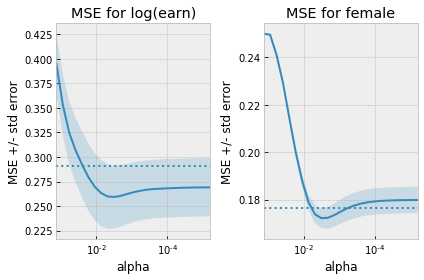

In [12]:
fig, ax = plt.subplots(1,2)

def plotlassocv(l, ax) :
    alphas = l.alphas_
    mse = l.mse_path_.mean(axis=1)
    std_error = l.mse_path_.std(axis=1)
    
    imin = np.argmin(l.mse_path_.mean(axis=1))
    msemin = l.mse_path_.mean(axis=1)[imin]
    se = l.mse_path_.std(axis=1)[imin]
    cutoff = msemin + se
    
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse + std_error, mse - std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    ax.axhline(cutoff, linestyle='dotted')

    return(ax)

ax[0] = plotlassocv(lassoy,ax[0])
ax[0].set_title("MSE for log(earn)")
ax[1] = plotlassocv(lassod,ax[1])
ax[1].set_title("MSE for female")
fig.tight_layout()

##We pick alpha using 

def pickalpha(lassocv) :
    imin = np.argmin(lassocv.mse_path_.mean(axis=1))
    msemin = lassocv.mse_path_.mean(axis=1)[imin]
    se = lassocv.mse_path_.std(axis=1)[imin]
    alpha= min([alpha for (alpha, mse) in zip(lassocv.alphas_, lassocv.mse_path_.mean(axis=1)) if mse<msemin+se])
    return(alpha)

alphay = pickalpha(lassoy)
alphad = pickalpha(lassod)

In [13]:
print("Alpha for female (d):", alphad)
print("Alpha for log earnings (y):", alphay)

Alpha for female (d): 0.0006011496416405784
Alpha for log earnings (y): 6.14421235332821e-06


####  <span style='color:green'> Step 1.c. <span style='color:green'>  Estimation of `yhat` and `dhat` using the best alpha for both outcomes estimted by cross validation previously </span>
    
You can predict $\hat y$ and $\hat d$ using `cross_val_predict` for each lasso model and a 5-fold cross-validation. 

In [14]:
from sklearn.linear_model import Lasso, LinearRegression
lasso_d=Lasso(alpha=alphad) 
lasso_y=Lasso(alpha=alphay) 

yhat = cross_val_predict(lasso_y,X_scaled,logearn,cv=5)
dhat = cross_val_predict(lasso_d,X_scaled,female,cv=5)

In [15]:
print(yhat.shape)
print(dhat.shape)

(13052,)
(13052,)


##  Step 2:    Partial out $x$: 
    
Let $\tilde y_i = y_i - \hat y_i$ and $\tilde d_i=d_i - \hat d_i$


In [16]:
ey = np.array(logearn - yhat)
ed = np.array(female - dhat)

## <span style='color:green'>  Step 3: Regress $\tilde y_i$ on $\tilde d_i$ to estimate $\hat \theta$
    
You can use 
`linear_model.OLS(y_variable,x_varible).fit(cov_type='HC0')` instead of `LinearRegression()` from `scikit-learn` to compute better standard errors (heteroscedastic robust: HC0)
   

In [17]:
lin_reg = LinearRegression()
lin_reg.fit(np.matrix(ey).T, np.matrix(ed).T)
lin_reg.coef_

array([[-0.07342268]])

In [18]:
from statsmodels.regression import linear_model

In [19]:
ols = linear_model.OLS(ey,ed).fit(cov_type='HC0')
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              97.75
Date:                Wed, 16 Jun 2021   Prob (F-statistic):                    5.72e-23
Time:                        16:56:31   Log-Likelihood:                         -9953.4
No. Observations:               13052   AIC:                                  1.991e+04
Df Residuals:                   13051   BIC:                                  1.992e+04
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1120      0.011     -9.887      0.000      -0.134      -0.090
==============================================================================
Omnibus:                     6380.234   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           304346.285
Skew:                          -1.616   Prob(JB):                         0.00
Kurtosis:                      26.435   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
"""

# <span style='color:green'>3. Visualization of the results

## <span style='color:green'>  3.a. Create a dataframe with log earnings, predicted log earnings ($\hat y_i$, by the lasso), female and predicted $d$ ($\hat d_i$ by the lasso) 

In [20]:
df = pd.DataFrame({"logearn":logearn,
                   "predicted":yhat,
                   "female":female,
                   "P(female|x)":dhat})

## <span style='color:green'>  3.b. Using the dataframe, plot the $y$ vs. $y_hat$ ie. observed and predicted log(earnings) for different colors for male and female. 
You can for example use `pairplot` from `seaborn`(the `hue` options allows you to attribute the color depending on a variable).

## <span style='color:green'>  3.c. Plot the distribution of errors ($y-\hat y$) with $\hat y$ on the x-axis with colors depending on gender. 
You can use a simple `scatterplot` from seaborn.

<Figure size 432x288 with 0 Axes>

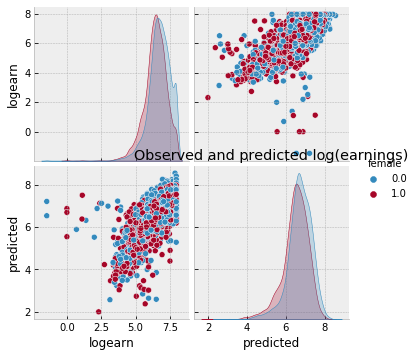

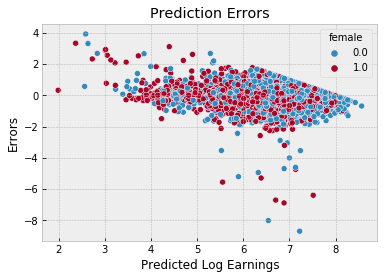

In [21]:
plt.figure()
sns.pairplot(df, vars=["logearn","predicted"], hue="female")
plt.title("Observed and predicted log(earnings)")
plt.show()

plt.figure()
sns.scatterplot(df.predicted, df.logearn-df.predicted, hue=df.female)
plt.ylabel('Errors')
plt.xlabel('Predicted Log Earnings')
plt.title("Prediction Errors")
plt.show()


# <span style='color:green'> 4. Comment on the results
    
<span style='color:green'> What is the estimated gender earnings gap conditional on $X$? How does it compare to the unconditional gender gap? 

We see that the gender earnings gap is 11.6%, conditional on hours, age, race, location, education, union membership, industry, and occupation. Compared to the gap conditional on only hours, differences in other observable characteristics in the CPS seem unable explain much of the gender earnings gap.